# 1-D Heat Transfer in a Water-Cooled Rocket Nozzle

## James Ho and Jinfay Justin Yuan

In [45]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import numpy as np

## Modeling

In order to determine the conditions of the engine throat wall over time, we created a system object that describes a slice of the model rocket. 

Using values that Justin had previously calculated for his model rocket engine, we defined the constant parameters of the rocket. 

To incorporate the startup of the rocket engine, we defined an array that would represent the temperature of the gas over time. Because the temperature would increase and reach a fixed value, we decided to use a sigmoid function to model our gas temperature over time. 

The calculations we conducted were based on the following assumptions:  
that q, the rate of heat flow, is constant throughout the whole simulation,  
the specific heat capacity of materials are the same even if they are one dimensional,  
that heat flows instantly across all materials from the gas to the coolant,  
and that the coolant has a fixed temperature (removes heat at a fixed rate)

Given these assumptions and intuition, we hypothesized that the temperature from highest to lowest were gas side wall, coolant side wall, and coolant. We also hypothesized that since the net heat rate at equilibrium is constant, the temperatures would reach an equilibrium.  


In [46]:
def make_system(twg, twc):
    """
    A function that returns a system object with a state called init
    The current system
    
    twg = Hot gas side local wall temperature
    twc = Coolant side local wall temperature
    tco = Temperature of Coolant Liquid (water)
    taw = Temperature of the hot combustion gases (K)
    hg = hot gas side heat transfer co-effficient = 2956
    k = thermal conductivity of Al 6061, W/(m*K)
    thickness = thickness of Al 6061 wall (m)
    hc = coolant side heat transfer co-efficient
    t_0 = intitial time 
    t_end = final time
    
    """
    system = System(init = State(twg = twg, taw = 3000, twc = twc, summ = 0),
                    hg = 2187,
                    k = 167 ,
                    thickness = .00238125,
                    hc = 32369,
                    q =  4905759, 
                    t_0 = 0,
                    t_end = 200,
                    mass = 0.5,
                    c_al = 900,
                    c_water = 4180,
                    dt = 0.01,
                    tco = 363)
    return system

In [47]:
system = make_system(397, 397)

,values
init,twg 397 taw 3000 twc 397 summ ...
hg,2187
k,167
thickness,0.00238125
hc,32369
q,4905759
t_0,0
t_end,200
mass,0.5
c_al,900


In [48]:
# Function of temperature with respect to time using a sigmoid function
time = np.linspace(0, 5, 500)
TawTemps = exp(5*time)/((1/system.init.taw)*exp(5*time)+1);

We now define all of the functions that we need to calculate each unknown separately. This way, it would be easy to integrate later on when we run the simulation.

In [49]:
def calculate_q(Twg, TawTemp):
    """
    Calculates the rate of heat transfer given the current gas temperature and gas side wall temperature
    Twg: Gas side wall temperature (K)
    TawTemp: The current gas temperature (K)
    returns: q
    """
    q = system.hg * (TawTemp - Twg);
    return q

In [50]:
def calculate_deltaT(system, q):
    """
    Calculates the change in temperature of the aluminum rocket wall given the rate of heat transfer at a system object
    system: system object containing dt
    q: rate of heat transfer
    returns: deltaT, the change in temperature
    """
    deltaT = (q * system.dt)/(system.mass * system.c_al)
    return deltaT

In [51]:
def calculate_next_Twg(Twg, deltaT):
    """
    Calculates the next gas side wall temperature given the change in temperature of the aluminum 
    Twg: the gas side wall temperature
    deltaT: the change in temperature
    returns: Twg of next iteration
    """
    return abs(Twg + deltaT)
    

In [52]:
def calculate_twc(system, Twg, q):
    """
    Calculates the coolant side wall temperature given the gas side wall temp and heat transfer rate and system
    system: system object
    Twg: the gas side wall temperature
    returns: twc
    """
    twc = Twg - (q * system.thickness)/system.k
    return twc

In [53]:
def calculate_twc1(system, q):
    """
    Calculates twc1 given the temperature of the coolant and heat transfer rate
    system: system object
    q: heat transfer rate
    returns: twc1
    """
    twc1 = (q/system.hc) + system.tco 
    return twc1

In [54]:
def calculate_twg1(system, twc1, q):
    """
    Calculates twg1 given the temperature of the coolant and heat transfer rate
    system: system object
    q: heat transfer rate
    returns: twg1
    """
    twg1 = ((q * system.thickness)/system.k) + twc1
    return twg1

In [55]:
def calculate_tco(system, Twc, q):
    """
    Calculates tco given the temperature of the coolant and heat transfer rate
    system: system object
    q: heat transfer rate
    returns: tco
    """
    tco = (Twc - (q/system.hc))
    return tco

Now we run and plot the results.

In [56]:
"""
For loop runs the operations in the desired order and appends results to arrays
"""
current_twg = system.init.twg
twgs = []
twcs = []
for i in range(len(TawTemps)):
    q = calculate_q(current_twg, TawTemps[i])
    deltaT = calculate_deltaT(system, q)
    
    twc1 = calculate_twc1(system, q)
    twg1 = calculate_twg1(system, twc1, q)
    q1 = calculate_q(twg1, TawTemps[i])
    
    next_Twg = calculate_next_Twg(twg1, deltaT)
    twg1 = next_Twg
    twcs.append(twc1)
    twgs.append(twg1)
   

    
# Have value Tco, use that to calulate Twc1
    

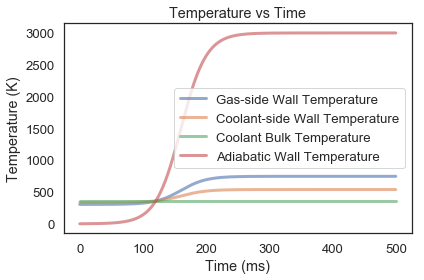

In [57]:
"""
Plot the arrays
"""
plot(range(len(twgs)), twgs, label='Gas-side Wall Temperature')
plot(range(len(twcs)), twcs, label='Coolant-side Wall Temperature')
plot(np.linspace(system.tco,system.tco,len(twgs)), label='Coolant Bulk Temperature')
plot(range(len(TawTemps)), TawTemps, label='Adiabatic Wall Temperature')
decorate(title='Temperature vs Time', xlabel='Time (ms)',
             ylabel='Temperature (K)')

These results agree with our hypothesis. The order of hottest to coolest is the gas-side wall, coolant-side wall, coolant bulk. We also see that the temperatures of all materials reached equilibria. 